# 1 Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

class MinMaxScaler3D(MinMaxScaler):
    """ Feature-wise scaling
        reshape data temporarily to [samples * time-steps , features] for feature-colums
        Code modified from https://stackoverflow.com/a/66650120,
        also https://stackoverflow.com/a/59601298"""
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

class StandardScaler3D(StandardScaler):
    """ Feature-wise scaling
        reshape data temporarily to [samples * time-steps , features] for feature-colums
        Code modified from https://stackoverflow.com/a/66650120,
        also https://stackoverflow.com/a/59601298"""
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

## Load & scale data

In [3]:
# Load data
data = np.load(r"data\data.npy")
target = np.load(r"data\target.npy")

In [4]:
# Scale data
data = StandardScaler3D().fit_transform(data)
# data = MinMaxScaler3D().fit_transform(data)

## 1.1 Baseline model (MLP)

(4000, 1500)

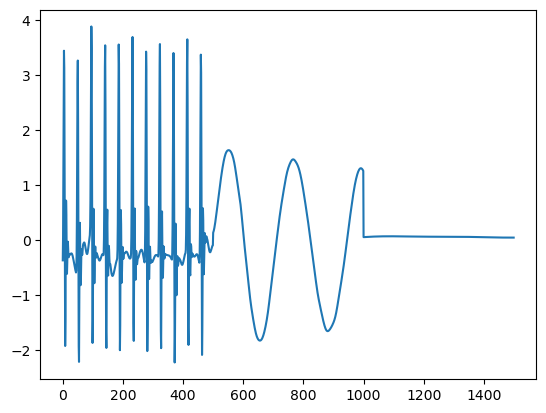

In [39]:
# Reshape data to 1-D for MLP
data_mlp = np.reshape(data, (
    data.shape[0],
    data.shape[2]*data.shape[1]
), order="F")

plt.plot(data_mlp[142]);
data_mlp.shape

## Sklearn implementation


In [40]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


model_mlp_sk = MLPClassifier(
    random_state=1, 
    max_iter=500, 
    early_stopping=True)
res = cross_validate(
    model_mlp_sk, 
    data_mlp, 
    target, 
    cv=5, n_jobs=-1,
    return_estimator=True)


# X_train, X_test, y_train, y_test = train_test_split(
#     data_mlp, target, stratify=target, random_state=1)

# clf = MLPClassifier(random_state=1, max_iter=500).fit(X_train, y_train)

# clf.score(X_test, y_test)


In [41]:
res

{'fit_time': array([18.9974606 , 13.0147059 , 13.81847763, 17.09749508, 17.85365558]),
 'score_time': array([0.01323128, 0.04833865, 0.0565877 , 0.02674317, 0.02013373]),
 'estimator': [MLPClassifier(early_stopping=True, max_iter=500, random_state=1),
  MLPClassifier(early_stopping=True, max_iter=500, random_state=1),
  MLPClassifier(early_stopping=True, max_iter=500, random_state=1),
  MLPClassifier(early_stopping=True, max_iter=500, random_state=1),
  MLPClassifier(early_stopping=True, max_iter=500, random_state=1)],
 'test_score': array([0.8225 , 0.745  , 0.7475 , 0.74375, 0.7925 ])}

## Tensorflow implementation

In [60]:
# MLP model 
# Code modified from https://github.com/hfawaz/dl-4-tsc/blob/master/classifiers/mlp.py

import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import time

import matplotlib 
matplotlib.use('agg')
import matplotlib.pyplot as plt 

from utils.utils import save_logs
from utils.utils import calculate_metrics

class Classifier_MLP:

	def __init__(self, output_directory, input_shape, nb_classes, verbose=False,build=True):
		self.output_directory = output_directory
		if build == True:
			self.model = self.build_model(input_shape, nb_classes)
			if(verbose==True):
				self.model.summary()
			self.verbose = verbose
			self.model.save_weights(self.output_directory + 'model_init.hdf5')
		return

	def build_model(self, input_shape, nb_classes):
		input_layer = keras.layers.Input(input_shape)

		# flatten/reshape because when multivariate all should be on the same axis 
		input_layer_flattened = keras.layers.Flatten()(input_layer)
		
		layer_1 = keras.layers.Dropout(0.1)(input_layer_flattened)
		layer_1 = keras.layers.Dense(500, activation='relu')(layer_1)

		layer_2 = keras.layers.Dropout(0.2)(layer_1)
		layer_2 = keras.layers.Dense(500, activation='relu')(layer_2)

		layer_3 = keras.layers.Dropout(0.2)(layer_2)
		layer_3 = keras.layers.Dense(500, activation='relu')(layer_3)

		output_layer = keras.layers.Dropout(0.3)(layer_3)
		output_layer = keras.layers.Dense(nb_classes, activation='softmax')(output_layer)

		model = keras.models.Model(inputs=input_layer, outputs=output_layer)

		model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adadelta(),
			metrics=['accuracy'])

		reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=200, min_lr=0.1)

		file_path = self.output_directory+'best_model.hdf5' 

		model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss', 
			save_best_only=True)

		self.callbacks = [reduce_lr,model_checkpoint]

		return model

	def fit(self, x_train, y_train, x_val, y_val,y_true):
		if not tf.test.is_gpu_available:
			print('error')
			exit()
		# x_val and y_val are only used to monitor the test loss and NOT for training  
		batch_size = 16
		nb_epochs = 5000

		mini_batch_size = int(min(x_train.shape[0]/10, batch_size))

		start_time = time.time() 

		hist = self.model.fit(x_train, y_train, batch_size=mini_batch_size, epochs=nb_epochs,
			verbose=self.verbose, validation_data=(x_val,y_val), callbacks=self.callbacks)
		
		duration = time.time() - start_time

		self.model.save(self.output_directory + 'last_model.hdf5')

		model = keras.models.load_model(self.output_directory+'best_model.hdf5')

		y_pred = model.predict(x_val)

		# convert the predicted from binary to integer 
		y_pred = np.argmax(y_pred , axis=1)

		save_logs(self.output_directory, hist, y_pred, y_true, duration)

		keras.backend.clear_session()

	def predict(self, x_test, y_true,x_train,y_train,y_test,return_df_metrics = True):
		model_path = self.output_directory + 'best_model.hdf5'
		model = keras.models.load_model(model_path)
		y_pred = model.predict(x_test)
		if return_df_metrics:
			y_pred = np.argmax(y_pred, axis=1)
			df_metrics = calculate_metrics(y_true, y_pred, 0.0)
			return df_metrics
		else:
			return 


ModuleNotFoundError: No module named 'tensorflow'

To do list
- add Group (stratified) k-fold cross-validation?

## 1.2 LSTM

Code modified from Master's thesis two-hearts

In [5]:
# Import libraries
import os
import datetime
import random
import numpy as np
from numpy import array, hstack
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

In [9]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    data, 
    target, 
    test_size = 0.25,
    stratify=target, 
    random_state=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (3000, 500)               1008000   
                                                                 
 dense_1 (Dense)             (3000, 1)                 501       
                                                                 
Total params: 1,008,501
Trainable params: 1,008,501
Non-trainable params: 0
_________________________________________________________________
None


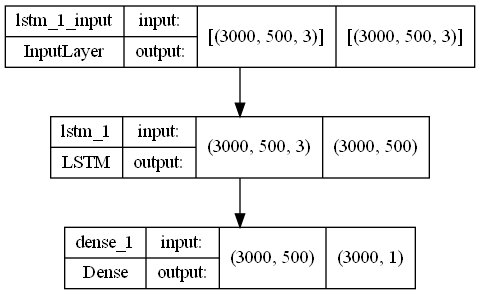

In [11]:
# Create the model

input_shape = (X_train.shape[0], X_train.shape[1], X_train.shape[2])

model = Sequential()
model.add(LSTM(500))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape)
print(model.summary())

plot_model(
    model,
    show_shapes=True,
    show_layer_names=True)



In [ ]:
    
model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
     epochs=3, 
     batch_size=64)

In [19]:
LSTM?

Init signature:
LSTM(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    time_major=False,
    unroll=False,
    **kwargs,
)
Docstring:     
Long Short-Term Memory layer - Hochreiter 1997.

See [the Keras RNN API guide](https://www.tensorflow.org/guide/keras/rnn)
for details about the usage of RNN API.

Based on available runtime hardware and constraints, this layer
will choose different implementations (cuDNN-based or pure-TensorFlow)
to maximize the performance. If a GP

In [14]:
def lstm_decoder_encoder(samples, units=100):
    # Input layer
    input_train = Input(
        shape=(
            samples["X_input_train"].shape[1],
            samples["X_input_train"].shape[2]))
    output_train = Input(
        shape=(
            samples["y_output_train"].shape[1],
            samples["y_output_train"].shape[2]))

    # Encoder LSTM with last state_h and state_c
    encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
        units,
        activation='elu',
        recurrent_dropout=0.1,
        return_sequences=False,
        return_state=True)(input_train)

    # Batch normalisation to avoid gradient explosion
    # center=False as mean is always 0
    encoder_last_h1 = BatchNormalization(
        momentum=0.6,
        center=False)(
            encoder_last_h1)
    encoder_last_c = BatchNormalization(
        momentum=0.6,
        center=False)(
            encoder_last_c)

    # Decoder LSTM
    decoder = RepeatVector(output_train.shape[1])(
        encoder_last_h1)
    decoder = LSTM(
        units,
        activation='elu',
        return_state=False,
        return_sequences=True)(
            decoder,
            initial_state=[
                encoder_last_h1,
                encoder_last_c])

    # Dense layer with repeated weights
    out = TimeDistributed(Dense(output_train.shape[2]))(
        decoder)

    # Compile model
    model = Model(
        inputs=input_train,
        outputs=out)
    opt = Adam(
        learning_rate=0.001,
        clipnorm=1)
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=['mae'])

    return model


(400, 500, 3)